In [1]:
import pandas as pd
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt

In [2]:
img = cv2.imread("D:/FloorplanToBlender3d-master/Images/Examples/Bedroom.png")


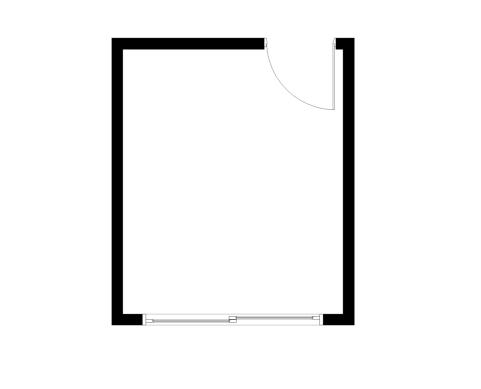

In [3]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [5]:
height, width, channels = img.shape

In [6]:
def wall_filter(gray):
    """
    Filter walls
    Filter out walls from a grayscale image
    @Param image
    @Return image of walls
    """
    _, thresh = cv2.threshold(
        gray,
        const.WALL_FILTER_TRESHOLD[0],
        const.WALL_FILTER_TRESHOLD[1],
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU,
    )

    # noise removal
    kernel = np.ones(const.WALL_FILTER_KERNEL_SIZE, np.uint8)
    opening = cv2.morphologyEx(
        thresh,
        cv2.MORPH_OPEN,
        kernel,
        iterations=const.WALL_FILTER_MORPHOLOGY_ITERATIONS,
    )

    sure_bg = cv2.dilate(
        opening, kernel, iterations=const.WALL_FILTER_DILATE_ITERATIONS
    )

    dist_transform = cv2.distanceTransform(
        opening, cv2.DIST_L2, const.WALL_FILTER_DISTANCE
    )
    ret, sure_fg = cv2.threshold(
        const.WALL_FILTER_DISTANCE_THRESHOLD[0] * dist_transform,
        const.WALL_FILTER_DISTANCE_THRESHOLD[1] * dist_transform.max(),
        const.WALL_FILTER_MAX_VALUE,
        const.WALL_FILTER_THRESHOLD_TECHNIQUE,
    )

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    return unknown

In [7]:
def wall_width_average(img):
    """
    This function calculate an average of all walls in floorplan.
    This is used to scale the size of the image for better accuracy.
    Returns the average as float value. See CALIBRATION in config file.
    """
    # grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resulting image
    height, width, channels = img.shape
    blank_image = np.zeros(
        (height, width, 3), np.uint8
    )  # output image same size as original

    # create wall image (filter out small objects from image)
    wall_img = detect.wall_filter(gray)
    print(type(wall_img))